In [ ]:
!pip install pyspark

## Data Cleaning .......................!

In [ ]:
import warnings

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import os

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
spark = SparkSession.builder.master("local[*]").appName("OurProject").getOrCreate()
df = spark.read.csv("/content/NYC Taxi Duration.csv", header=True)
df.printSchema()


root
 |-- _c0: string (nullable = true)
 |-- id: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: string (nullable = true)



In [ ]:
df.show()

+---+---------+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|_c0|       id|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|
+---+---------+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|  0|id2875421|        2|3/14/2016 17:24| 3/14/2016 17:32|              1|    -73.98215485|    40.76793671|     -73.96463013|     40.76560211|                 N|          455|
|  1|id2377394|        1| 6/12/2016 0:43|  6/12/2016 0:54|              1|    -73.98041534|    40.73856354|      -73.9994812|     40.73115158|                 N|          663|
|  2|id3858529|        2|1/19/2016 11:35| 1/19/2016 12:10|              1|    -73.97902679|     40.7639389|     -74.0053

In [ ]:
df = df.drop(df._c0)
df = df.drop(df.id)

In [ ]:
df.show()

+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|        2|3/14/2016 17:24| 3/14/2016 17:32|              1|    -73.98215485|    40.76793671|     -73.96463013|     40.76560211|                 N|          455|
|        1| 6/12/2016 0:43|  6/12/2016 0:54|              1|    -73.98041534|    40.73856354|      -73.9994812|     40.73115158|                 N|          663|
|        2|1/19/2016 11:35| 1/19/2016 12:10|              1|    -73.97902679|     40.7639389|     -74.00533295|     40.71008682|                 N|         2124|
|        2| 4/6/2016 19:32| 

## Checking unacceptable values

In [ ]:
# Checking for NaN or null values

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|        0|              0|               0|              0|               0|              0|                0|               0|                 0|            0|
+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+



In [ ]:
# Count the number of entries where trip_duration is less than 0.

df.filter(df.trip_duration <= 0).count()

0

In [ ]:
# Checking for unique values in `store_and_fwd_flag`

df.select('store_and_fwd_flag').distinct().collect()

[Row(store_and_fwd_flag='Y'), Row(store_and_fwd_flag='N')]

In [ ]:
# Checking for unique values in `vendor_id`

df.select('vendor_id').distinct().collect()

[Row(vendor_id='1'), Row(vendor_id='2')]

In [ ]:
df.show()

+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|        2|3/14/2016 17:24| 3/14/2016 17:32|              1|    -73.98215485|    40.76793671|     -73.96463013|     40.76560211|                 N|          455|
|        1| 6/12/2016 0:43|  6/12/2016 0:54|              1|    -73.98041534|    40.73856354|      -73.9994812|     40.73115158|                 N|          663|
|        2|1/19/2016 11:35| 1/19/2016 12:10|              1|    -73.97902679|     40.7639389|     -74.00533295|     40.71008682|                 N|         2124|
|        2| 4/6/2016 19:32| 

In [ ]:
if os.path.exists("./NYC Taxi Duration Cleaned") == False:
    df.write.option("header", "true").csv("./NYC Taxi Duration Cleaned")

## Data Preprocessing .............................!

In [ ]:
!pip install -q scikit-learn

In [ ]:
from pyspark.sql import functions
from pyspark.sql.types import FloatType
from sklearn.preprocessing import StandardScaler
from math import radians, cos, sin, asin, sqrt
import sys
from pyspark.sql.functions import to_timestamp

### Getting Cleaned Data

In [ ]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [ ]:
spark = SparkSession.builder.appName("MyApp").master("local[*]").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
df = spark.read.csv("/content/NYC Taxi Duration Cleaned/*.csv", header=True)
df.printSchema()
df.show()

root
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: string (nullable = true)

+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|        2|3/14/2016 17:24| 3/14/2016 

In [ ]:
df.count()

425545

In [ ]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


## Preprocessing & adding additional data into DataFrame

In [ ]:
# Changing Datatype for each column.

def change_type(df, column_name, column_type, is_time):
    if column_type == "int" or column_type == "float":
        new_df = df.withColumn(column_name, df[column_name].cast(column_type))
    elif column_type == "bool":
        new_df = df.withColumn(column_name, functions.when(df[column_name] == 'N', 0).otherwise(1))
    elif is_time:
        new_df = df.withColumn(column_name, to_timestamp(df[column_name], "M/d/yyyy H:mm"))
    else:
        new_df = df
    return new_df


In [ ]:
# Calling change_type function for each column.

column_types = ["int", "time", "time", "int", "float", "float", "float", "float", "bool", "int"]
count = 0

for col in df.dtypes:
    if column_types[count] == "time":
        df = change_type(df, col[0], column_types[count], True)
    else:
        df = change_type(df, col[0], column_types[count], False)
    count += 1

In [ ]:
# Printing Datatype for all columns.

for col in df.dtypes:
    print(col[0]+" , "+col[1])

vendor_id , int
pickup_datetime , timestamp
dropoff_datetime , timestamp
passenger_count , int
pickup_longitude , float
pickup_latitude , float
dropoff_longitude , float
dropoff_latitude , float
store_and_fwd_flag , int
trip_duration , int


In [ ]:
df.show()

+---------+-------------------+-------------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+-------------------+-------------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|        2|2016-03-14 17:24:00|2016-03-14 17:32:00|              1|      -73.982155|      40.767937|        -73.96463|       40.765602|                 0|          455|
|        1|2016-06-12 00:43:00|2016-06-12 00:54:00|              1|      -73.980415|      40.738564|        -73.99948|        40.73115|                 0|          663|
|        2|2016-01-19 11:35:00|2016-01-19 12:10:00|              1|       -73.97903|       40.76394|        -74.00533|       40.710087|                 0| 

In [ ]:
# Calculating distance between two places.

def distance(pickUpLat1, dropOffLat2, pickUpLon1, dropOffLon2):
    longitude = radians(dropOffLon2) - radians(pickUpLon1)
    x = sin(longitude / 2)**2 + cos(radians(pickUpLat1)) * cos(radians(dropOffLat2)) * sin(longitude / 2)**2

    temp = 2 * asin(sqrt(x))
    earth_radius = 6371
    return(temp * earth_radius)

In [ ]:
# Calculating distance between pickup and dropoff latitude and longtitude. In (K.M.)

distance_func = udf(distance, FloatType())
df = df.withColumn("distance", distance_func(df.pickup_latitude, df.dropoff_latitude, df.pickup_longitude, df.dropoff_longitude))

In [ ]:
# filter the data where distance is greater than 0.

df = df.filter(df.distance > 0)

In [ ]:
# Removing all trips that have trip_duration more than 7200 seconds which is equivalent to more than 2 hours and less than 180 seconds.
# Removing all trips which total distance is less than 1.5 and more than 60 KM because no taxi accepts rides as the destination is more than 60 kilometers far away.

df = df.filter((df.trip_duration > 180) & (df.trip_duration < 7200) & (df.distance > 1.5) & (df.distance < 60))


In [ ]:
df.show()

+---------+-------------------+-------------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+---------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration| distance|
+---------+-------------------+-------------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+---------+
|        2|2016-03-14 17:24:00|2016-03-14 17:32:00|              1|      -73.982155|      40.767937|        -73.96463|       40.765602|                 0|          455|2.4444735|
|        1|2016-06-12 00:43:00|2016-06-12 00:54:00|              1|      -73.980415|      40.738564|        -73.99948|        40.73115|                 0|          663|2.6599078|
|        2|2016-01-19 11:35:00|2016-01-19 12:10:00|              1|       -73.97903|       40.76394|     

### Adding timeline for each ride

In [ ]:
df = df.withColumn("week_day", date_format(df["pickup_datetime"], "E"))
df = df.withColumn('year', date_format(df["pickup_datetime"], "y"))
df = df.withColumn('month', date_format(df["pickup_datetime"], "M"))
df = df.withColumn('quarter_of_year', quarter('pickup_datetime'))
df = df.withColumn('hour', date_format(df["pickup_datetime"], "H"))

df = df.drop("pickup_datetime")
df = df.drop("dropoff_datetime")

In [ ]:
df.show()

+---------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+---------+--------+----+-----+---------------+----+
|vendor_id|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration| distance|week_day|year|month|quarter_of_year|hour|
+---------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+---------+--------+----+-----+---------------+----+
|        2|              1|      -73.982155|      40.767937|        -73.96463|       40.765602|                 0|          455|2.4444735|     Mon|2016|    3|              1|  17|
|        1|              1|      -73.980415|      40.738564|        -73.99948|        40.73115|                 0|          663|2.6599078|     Sun|2016|    6|              2|   0|
|        2|              1|       -73.97903|       40.76394|        -74.00533|       40.710087|     

In [ ]:
df.count()

239699

### Saving Preprocessed Data

In [ ]:
if os.path.exists("./NYC Taxi Duration Preprocessed") == False:
    df.write.option("header", "true").csv("./NYC Taxi Duration Preprocessed")

## Data Visualization .............................!

In [ ]:
!pip install -q numpy
!pip install -q matplotlib
!pip install -q pandas
!pip install -q pyrolite
!pip install -q pyro-ppl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.7 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde


%matplotlib inline

In [ ]:
spark = SparkSession.builder.appName("MyApp2").master("local[*]").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
df = spark.read.csv("/content/NYC Taxi Duration Preprocessed/*.csv", header=True)
df.printSchema()
df.show()

root
 |-- vendor_id: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- week_day: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- quarter_of_year: string (nullable = true)
 |-- hour: string (nullable = true)

+---------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+---------+--------+----+-----+---------------+----+
|vendor_id|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration| distance|week_day|year|month|quarter_of_year|hour|
+---------+------------

In [ ]:
df.count()

395997

In [ ]:
from pyspark.sql.types import IntegerType, DoubleType

# Define column types explicitly
df = df.withColumn("vendor_id", df["vendor_id"].cast(IntegerType())) \
       .withColumn("passenger_count", df["passenger_count"].cast(IntegerType())) \
       .withColumn("pickup_longitude", df["pickup_longitude"].cast(DoubleType())) \
       .withColumn("pickup_latitude", df["pickup_latitude"].cast(DoubleType())) \
       .withColumn("dropoff_longitude", df["dropoff_longitude"].cast(DoubleType())) \
       .withColumn("dropoff_latitude", df["dropoff_latitude"].cast(DoubleType())) \
       .withColumn("store_and_fwd_flag", df["store_and_fwd_flag"].cast(IntegerType())) \
       .withColumn("trip_duration", df["trip_duration"].cast(IntegerType())) \
       .withColumn("distance", df["distance"].cast(DoubleType())) \
       .withColumn("year", df["year"].cast(IntegerType())) \
       .withColumn("month", df["month"].cast(IntegerType())) \
       .withColumn("quarter_of_year", df["quarter_of_year"].cast(IntegerType())) \
       .withColumn("hour", df["hour"].cast(IntegerType()))

df.printSchema()
df.show()


root
 |-- vendor_id: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: integer (nullable = true)
 |-- trip_duration: integer (nullable = true)
 |-- distance: double (nullable = true)
 |-- week_day: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- quarter_of_year: integer (nullable = true)
 |-- hour: integer (nullable = true)

+---------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+---------+--------+----+-----+---------------+----+
|vendor_id|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration| distance|week_day|year|month|quarter_of_year|hour|
+---------+----

### Total Trips and Passenger Count on different week days

<Figure size 2000x1000 with 0 Axes>

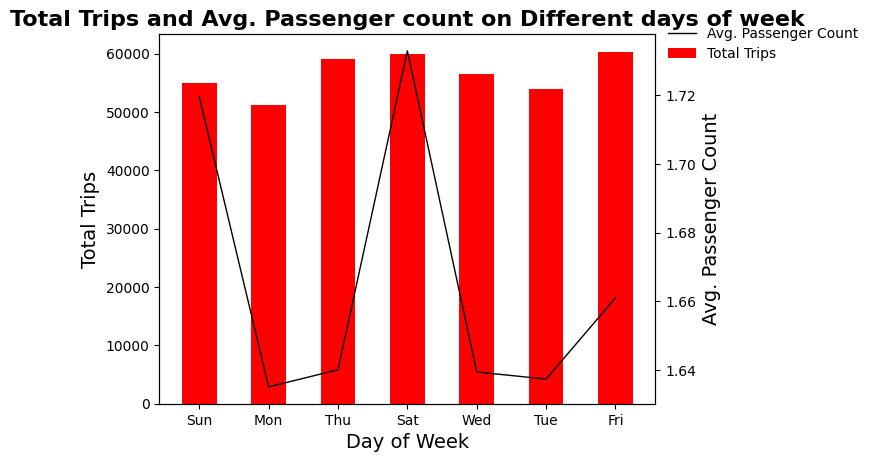

In [ ]:
# Total Trips and Average Passenger Count on different week days.

df_total_trip_on_diff_week_day = df.groupBy("week_day").count()
df_avg_pass_count = df.groupBy("week_day").mean("passenger_count")

df_total_trip_pass_mean_on_diff_week_day = df_total_trip_on_diff_week_day.join(df_avg_pass_count, df_total_trip_on_diff_week_day["week_day"] == df_avg_pass_count["week_day"])

plt.figure(figsize=(20, 10), dpi=100)
fig, first_axes = plt.subplots()

x = df_total_trip_pass_mean_on_diff_week_day.toPandas().iloc[:, :1].values.flatten()
y1 = df_total_trip_pass_mean_on_diff_week_day.toPandas()['count'].values
y2 = df_total_trip_pass_mean_on_diff_week_day.toPandas()['avg(passenger_count)'].values

total_trip_duration = first_axes.bar(x, y1, color ='red',width = 0.5)

second_axes = first_axes.twinx()
mean_passenger_count = second_axes.plot(x, y2, c="black")

first_axes.set_xlabel('Day of Week', fontweight='normal', fontsize=14)
first_axes.set_ylabel('Total Trips', fontweight='normal', fontsize=14)
second_axes.set_ylabel('Avg. Passenger Count', fontweight='normal', fontsize=14)

first_axes.legend((total_trip_duration), [('Total Trips')], loc=0)
second_axes.legend((mean_passenger_count), [('Avg. Passenger Count')], loc=6)
plt.title('Total Trips and Avg. Passenger count on Different days of week', fontweight='bold', fontsize=16)
plt.show()


### Mean Distance and trip duration on different week days

<Figure size 2000x1000 with 0 Axes>

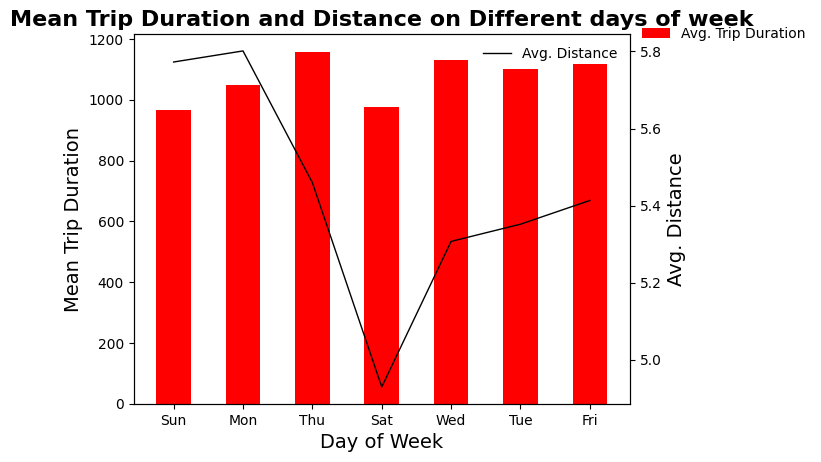

In [ ]:
# Average Trip Duration and Average Distance on different week days.

df_trip_dur_on_diff_week_day = df.groupBy("week_day").mean("trip_duration")
df_mean_distance = df.groupBy("week_day").mean("distance")

df_trip_dur_distance_mean_on_diff_week_day = df_trip_dur_on_diff_week_day.join(df_mean_distance, df_trip_dur_on_diff_week_day["week_day"] == df_mean_distance["week_day"])

plt.figure(figsize=(20, 10), dpi=100)
fig, first_axes = plt.subplots()

x = df_trip_dur_distance_mean_on_diff_week_day.toPandas().iloc[:, :1].values.flatten()
y1 = df_trip_dur_distance_mean_on_diff_week_day.toPandas()['avg(trip_duration)'].values
y2 = df_trip_dur_distance_mean_on_diff_week_day.toPandas()['avg(distance)'].values

avg_trip_duration = first_axes.bar(x, y1, color ='red',width = 0.5)

second_axes = first_axes.twinx()
mean_distance = second_axes.plot(x, y2, c="black")

first_axes.set_xlabel('Day of Week', fontweight='normal', fontsize=14)
first_axes.set_ylabel('Mean Trip Duration', fontweight='normal', fontsize=14)
second_axes.set_ylabel('Avg. Distance', fontweight='normal', fontsize=14)

first_axes.legend((avg_trip_duration), [('Avg. Trip Duration')], loc=6)
second_axes.legend((mean_distance), [('Avg. Distance')], loc=0)

plt.title('Mean Trip Duration and Distance on Different days of week', fontweight='bold', fontsize=16)
plt.show()


## Distance and Trip Duration

In [ ]:
# Selecting two columns

distance = df.select('distance').toPandas().values
trip_duration = df.select('trip_duration').toPandas().values

In [ ]:
# Create dataframe of distance and trip_duration columns.

df_dist_trip_time = pd.DataFrame({'distance': distance.flatten(), 'trip_duration': trip_duration.flatten()})

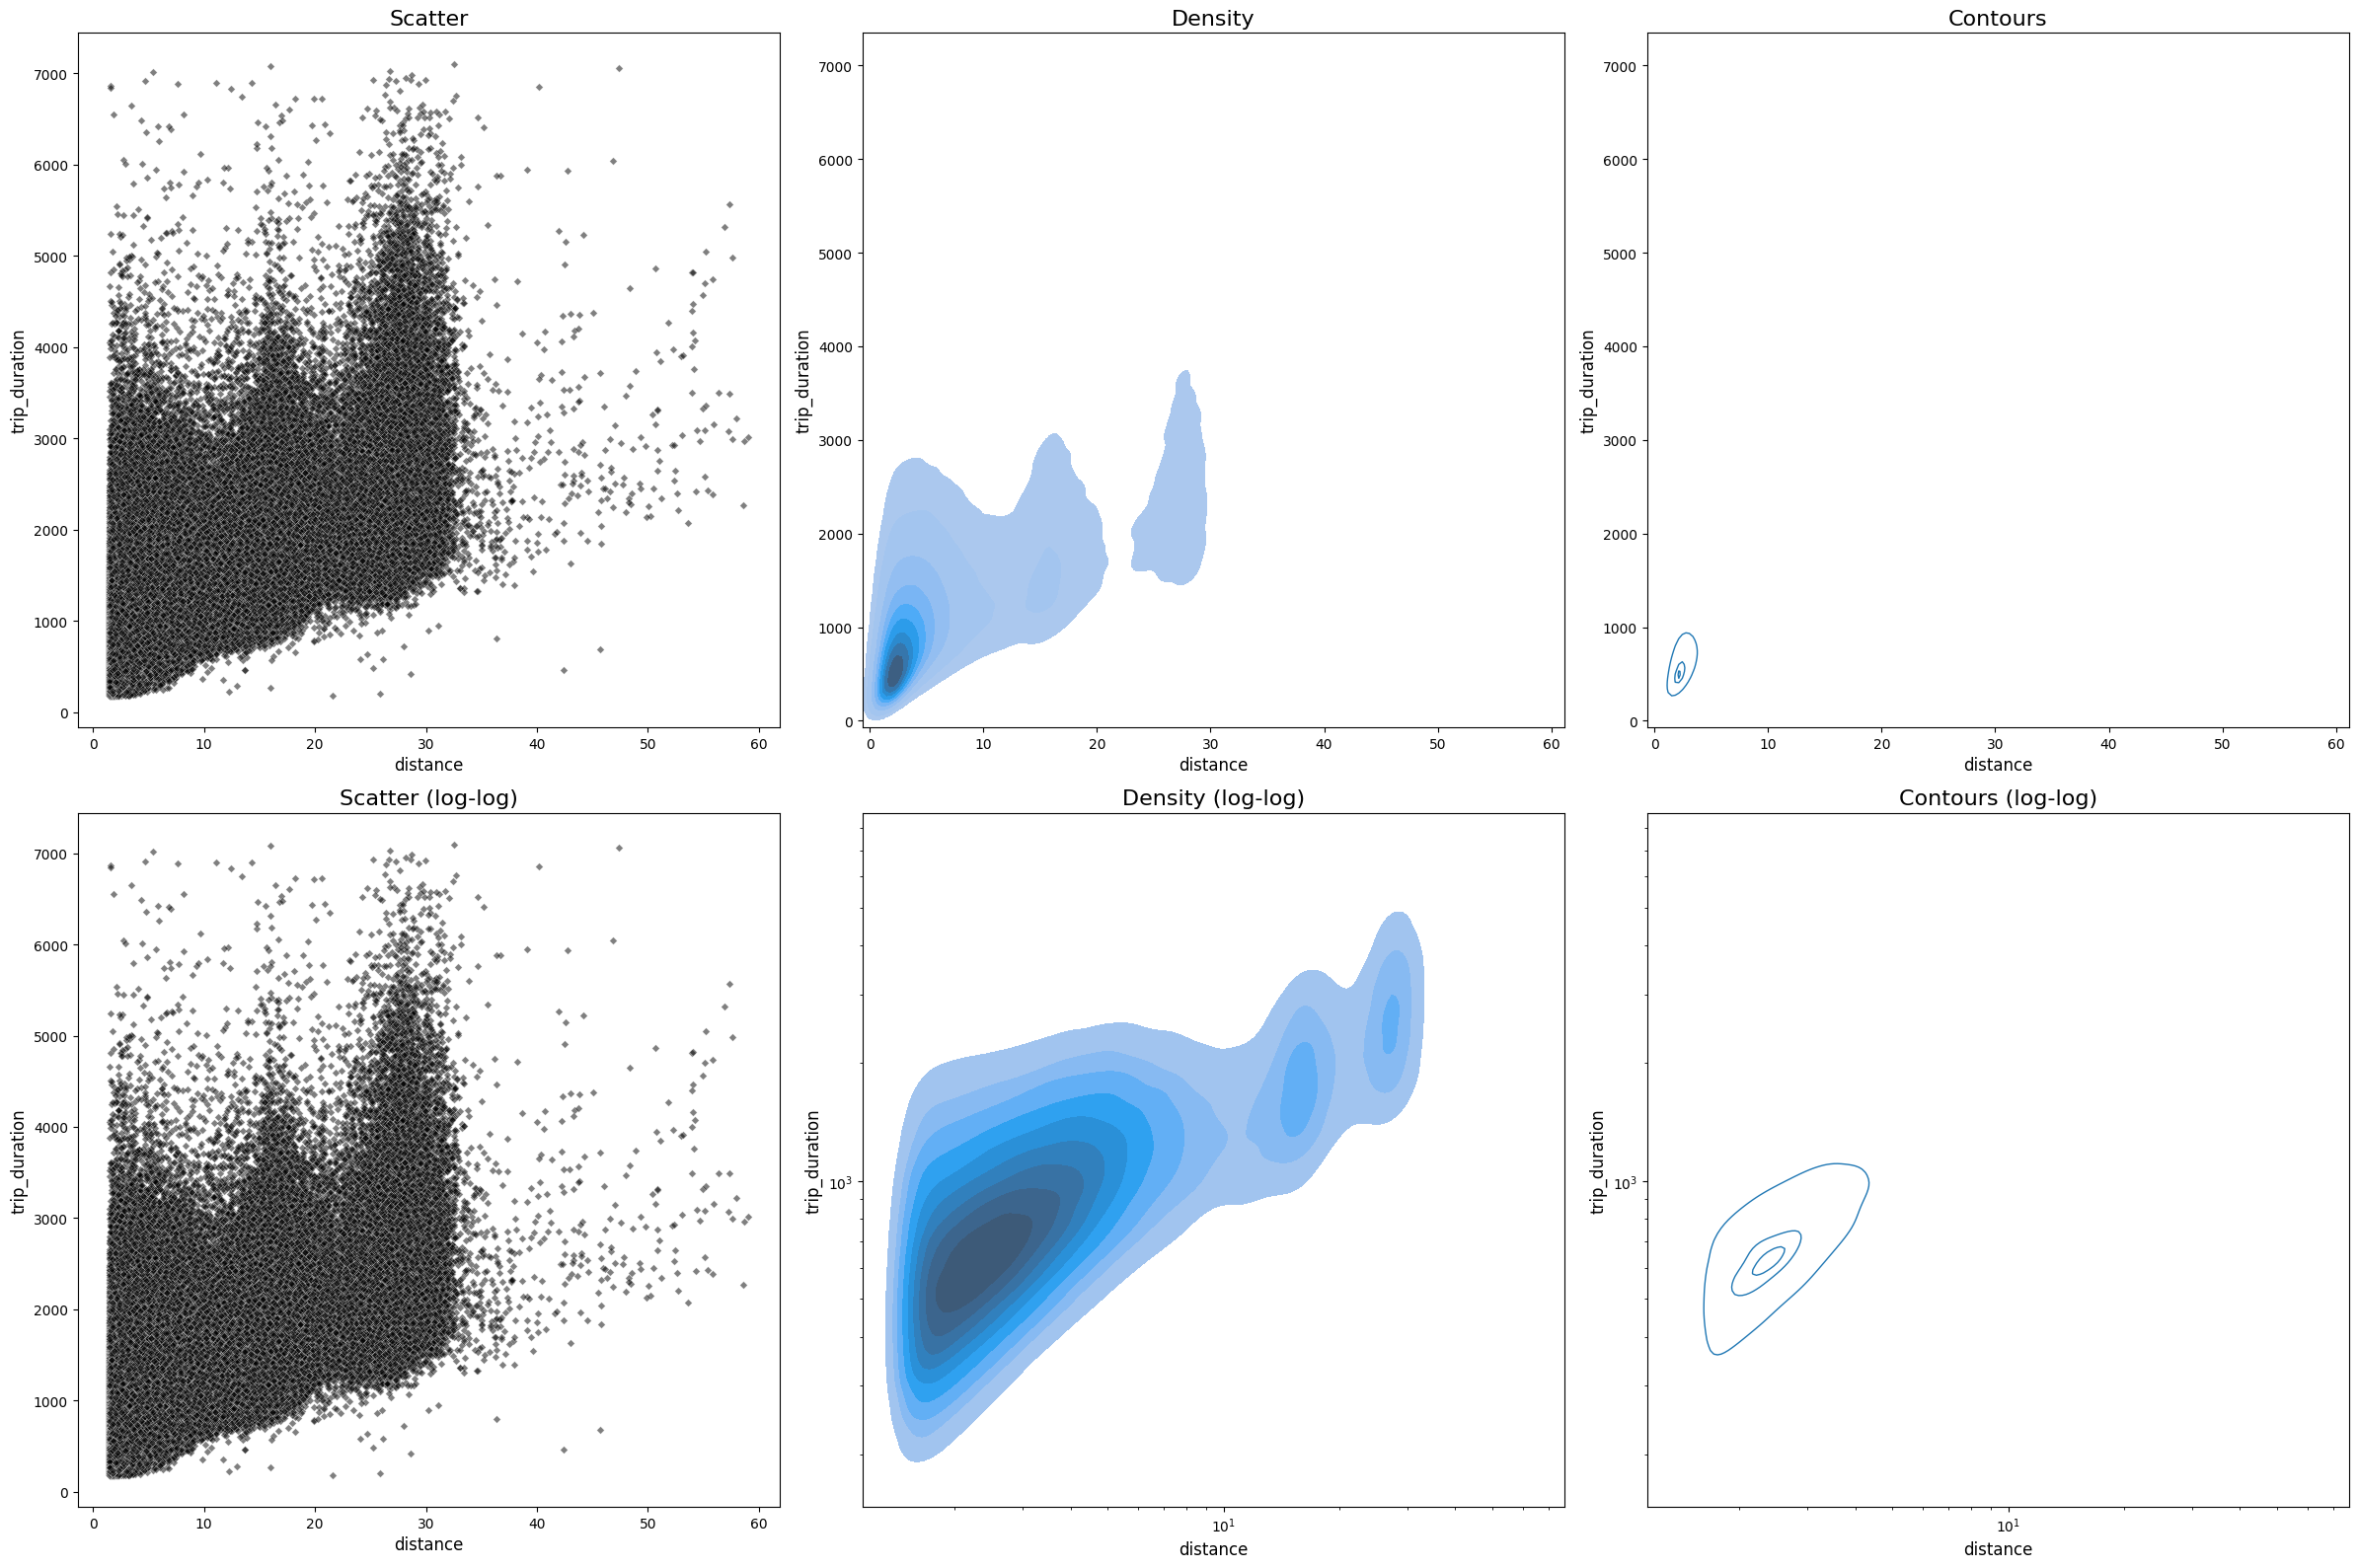

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(24, 16))
ax = ax.flat

columns = ["distance", "trip_duration"]
contours = [0.68, 0.95, 0.99]

# Scatter plot (linear scale)
sns.scatterplot(data=df_dist_trip_time, x="distance", y="trip_duration", ax=ax[0], color="k", s=15, alpha=0.5)
sns.kdeplot(data=df_dist_trip_time, x="distance", y="trip_duration", ax=ax[1], fill=True)
sns.kdeplot(data=df_dist_trip_time, x="distance", y="trip_duration", ax=ax[2], levels=contours)

# Scatter plot (log-log scale)
sns.scatterplot(data=df_dist_trip_time, x="distance", y="trip_duration", ax=ax[3], color="k", s=15, alpha=0.5)
sns.kdeplot(data=df_dist_trip_time, x="distance", y="trip_duration", ax=ax[4], fill=True, log_scale=True)
sns.kdeplot(data=df_dist_trip_time, x="distance", y="trip_duration", ax=ax[5], levels=contours, log_scale=True)

# Titles
titles = ["Scatter", "Density", "Contours"]
for chart_title, a in zip(titles + [i + " (log-log)" for i in titles], ax):
    a.set_title(chart_title, fontsize=16)

plt.tight_layout()
plt.show()


# Regression Models Implementation...................................

In [ ]:
!pip install pyspark

In [ ]:
# Importing libraries

from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
# Getting preprocessed data

spark = SparkSession.builder.appName("MyAppML").master("local[*]").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
df = spark.read.csv("/content/NYC Taxi Duration Preprocessed/*.csv", header=True)

In [ ]:
from pyspark.sql.types import IntegerType, DoubleType

# Define column types explicitly
df = df.withColumn("vendor_id", df["vendor_id"].cast(IntegerType())) \
       .withColumn("passenger_count", df["passenger_count"].cast(IntegerType())) \
       .withColumn("pickup_longitude", df["pickup_longitude"].cast(DoubleType())) \
       .withColumn("pickup_latitude", df["pickup_latitude"].cast(DoubleType())) \
       .withColumn("dropoff_longitude", df["dropoff_longitude"].cast(DoubleType())) \
       .withColumn("dropoff_latitude", df["dropoff_latitude"].cast(DoubleType())) \
       .withColumn("store_and_fwd_flag", df["store_and_fwd_flag"].cast(IntegerType())) \
       .withColumn("trip_duration", df["trip_duration"].cast(IntegerType())) \
       .withColumn("distance", df["distance"].cast(DoubleType())) \
       .withColumn("year", df["year"].cast(IntegerType())) \
       .withColumn("month", df["month"].cast(IntegerType())) \
       .withColumn("quarter_of_year", df["quarter_of_year"].cast(IntegerType())) \
       .withColumn("hour", df["hour"].cast(IntegerType()))

df.printSchema()
df.show()


root
 |-- vendor_id: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: integer (nullable = true)
 |-- trip_duration: integer (nullable = true)
 |-- distance: double (nullable = true)
 |-- week_day: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- quarter_of_year: integer (nullable = true)
 |-- hour: integer (nullable = true)

+---------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+---------+--------+----+-----+---------------+----+
|vendor_id|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration| distance|week_day|year|month|quarter_of_year|hour|
+---------+----

# Preparing df for ML models

In [ ]:
# Convert week day string column into index column.
label_index = StringIndexer(inputCol = 'week_day', outputCol = 'week_day_index')
df = label_index.fit(df).transform(df)
df.show()

+---------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+---------+--------+----+-----+---------------+----+--------------+
|vendor_id|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration| distance|week_day|year|month|quarter_of_year|hour|week_day_index|
+---------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+---------+--------+----+-----+---------------+----+--------------+
|        2|              1|      -73.982155|      40.767937|        -73.96463|       40.765602|                 0|          455|2.4444735|     Mon|2016|    3|              1|  17|           6.0|
|        1|              1|      -73.980415|      40.738564|        -73.99948|        40.73115|                 0|          663|2.6599078|     Sun|2016|    6|              2|   0|           4.0|
|        2|              

In [ ]:
# Creating a list of input columns headers
input_col = [i[0] for i in df.dtypes if i[1] == "int" or i[1] == "double"]
input_col.remove("trip_duration")

# Creating a dataframe of input columns.
input_features = VectorAssembler(inputCols = input_col, outputCol = "input_features")
input_column = input_features.transform(df)
input_column.select("input_features").show()

+--------------------+
|      input_features|
+--------------------+
|[2.0,1.0,-73.9821...|
|[1.0,1.0,-73.9804...|
|[2.0,1.0,-73.9790...|
|[1.0,4.0,-73.9690...|
|[2.0,1.0,-73.9692...|
|[1.0,1.0,-73.9994...|
|[2.0,1.0,-73.9826...|
|[2.0,4.0,-73.9915...|
|[2.0,2.0,-73.9629...|
|[2.0,1.0,-73.9921...|
|[1.0,1.0,-74.0039...|
|[1.0,1.0,-73.9803...|
|[2.0,1.0,-73.9795...|
|[1.0,1.0,-73.9935...|
|[2.0,1.0,-73.9552...|
|[2.0,1.0,-73.9565...|
|[1.0,1.0,-73.9837...|
|[2.0,1.0,-73.9942...|
|[1.0,1.0,-73.9821...|
|[1.0,1.0,-73.9709...|
+--------------------+
only showing top 20 rows



In [ ]:
data_frame = input_column.select("input_features", "trip_duration")
data_frame.show(5)

+--------------------+-------------+
|      input_features|trip_duration|
+--------------------+-------------+
|[2.0,1.0,-73.9821...|          455|
|[1.0,1.0,-73.9804...|          663|
|[2.0,1.0,-73.9790...|         2124|
|[1.0,4.0,-73.9690...|          341|
|[2.0,1.0,-73.9692...|         1551|
+--------------------+-------------+
only showing top 5 rows



## Linear Regression model

In [ ]:
# Split training and testing dataset for the models.
train, test = data_frame.randomSplit([0.7, 0.3])

# linear regression model.
linear_regression = LinearRegression(labelCol = "trip_duration", featuresCol = "input_features")

# Create ParamGrid for Cross Validation.
linear_regression_param_grid = ParamGridBuilder() \
                                .addGrid(linear_regression.regParam, [0.01, 0.1, 0.5, 1.0, 2.0]) \
                                .addGrid(linear_regression.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
                                .addGrid(linear_regression.maxIter, [1, 5, 10, 20, 50]) \
                                .addGrid(linear_regression.fitIntercept, [True, False]) \
                                .build()

# evaluator with the root mean square error metric.
evaluator = RegressionEvaluator(predictionCol = "prediction", labelCol = "trip_duration", metricName = "rmse")

# cross validator with total 5 folds.
cross_validator = CrossValidator(estimator = linear_regression,
                      estimatorParamMaps = linear_regression_param_grid,
                      evaluator = evaluator,
                      numFolds = 5)

In [ ]:
# Training a linear regression model.
model = cross_validator.fit(train)

In [ ]:
import builtins

In [ ]:
# Print best parameter of the model.
print("Best Regression Param: ", model.bestModel._java_obj.getRegParam())
print("Best Elastic Net Param: ", model.bestModel._java_obj.getElasticNetParam())
print("Best maxIter Param: ", model.bestModel._java_obj.getMaxIter())
print("Best fitIntercept Param: ", model.bestModel._java_obj.getFitIntercept())
print("Intercept: ", model.bestModel.intercept)

# Acuracy and coefficients of the linear equation.
print("Coefficient of Determination(Accuracy on Training data): ", str(builtins.round(model.bestModel.summary.r2*100, 2)), "%")

print("Coefficients: ", model.bestModel.coefficients)

Best Regression Param:  0.5
Best Elastic Net Param:  0.5
Best maxIter Param:  10
Best fitIntercept Param:  True
Intercept:  -16370.771616650196
Coefficient of Determination(Accuracy on Training data):  49.81 %
Coefficients:  [0.0,1.4566420188629612,-304.68934862633523,-259.7897210793952,-547.7232649201464,-874.0775904814695,66.6653198253338,81.89862093727054,0.0,18.418179804523927,25.202318615269423,5.210294923686946,-8.215819353094664]


In [ ]:
# Predict.
prediction = model.transform(test)

prediction.show(5)

+--------------------+-------------+------------------+
|      input_features|trip_duration|        prediction|
+--------------------+-------------+------------------+
|[1.0,1.0,-74.0176...|          897|1030.3234130035016|
|[1.0,1.0,-74.0174...|         1180|  882.268325379744|
|[1.0,1.0,-74.0174...|          710| 1098.396038527113|
|[1.0,1.0,-74.0172...|         1244|1066.0073570368622|
|[1.0,1.0,-74.0172...|          926| 857.1683060988471|
+--------------------+-------------+------------------+
only showing top 5 rows



In [ ]:
# Evaluator for testing data.
test_pred_evaluator = RegressionEvaluator(predictionCol = "prediction", labelCol = "trip_duration", metricName = "r2")

# Print RMSE and accuracy of the model on testing data.
print("RMSE: ", evaluator.evaluate(prediction))
print("Coefficient of Determination(Accuracy on Test Data): ", str(builtins.round(test_pred_evaluator.evaluate(prediction)*100, 4)), "%")


RMSE:  0.5039334652369498
Coefficient of Determination(Accuracy on Test Data):  50.3933 %


## Gradient Boosted Trees Regression

In [ ]:
# Gradient Boosted Trees regression instance.
gbtr = GBTRegressor(featuresCol="input_features", labelCol="trip_duration")

# Create ParamGrid for Cross Validation of gradient boosted trees regression.
gradient_boosted_trees_param_grid = ParamGridBuilder() \
                                .addGrid(gbtr.maxDepth, [5, 10]) \
                                .addGrid(gbtr.maxIter, [5, 10, 20]) \
                                .addGrid(gbtr.maxBins, [32, 64]) \
                                .build()

# evaluator with the root mean square error metric for gbtr.
gbt_evaluator = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="rmse")

# Cross validator for gbtr with 5 total folds.
cross_validator_gbtr = CrossValidator(estimator = gbtr,
                      estimatorParamMaps = gradient_boosted_trees_param_grid,
                      evaluator = gbt_evaluator,
                      numFolds = 5)

In [ ]:
# Training a gradient boosted trees regression model.
model_gbtr = cross_validator_gbtr.fit(train)

In [ ]:
# Print best depth, bins, maxIter, impurity and losstype.
print("Best maxDepth Param: ", model_gbtr.bestModel._java_obj.getMaxDepth())
print("Best maxBins Param: ", model_gbtr.bestModel._java_obj.getMaxBins())
print("Best maxIter Param: ", model_gbtr.bestModel._java_obj.getMaxIter())
print("Best impurity Param: ", model_gbtr.bestModel._java_obj.getImpurity())
print("Best lossType Param: ", model_gbtr.bestModel._java_obj.getLossType())

Best maxDepth Param:  10
Best maxBins Param:  32
Best maxIter Param:  20
Best impurity Param:  variance
Best lossType Param:  squared


In [ ]:
# Predict.
prediction_gbtr = model_gbtr.transform(test)

prediction_gbtr.show(5)

+--------------------+-------------+------------------+
|      input_features|trip_duration|        prediction|
+--------------------+-------------+------------------+
|[1.0,1.0,-74.0176...|          897| 994.4369327523638|
|[1.0,1.0,-74.0174...|         1180|  984.899384427757|
|[1.0,1.0,-74.0174...|          710| 1366.783549125626|
|[1.0,1.0,-74.0172...|         1244|1497.7118877615956|
|[1.0,1.0,-74.0172...|          926| 680.8704499632144|
+--------------------+-------------+------------------+
only showing top 5 rows



In [ ]:
# Evaluator for testing data for gradient boosted trees regression model.
test_pred_evaluator_gbtr = RegressionEvaluator(predictionCol = "prediction", labelCol = "trip_duration", metricName = "r2")

# Print RMSE and accuracy of the model on testing data for gradient boosted trees regression.
print("RMSE: ", gbt_evaluator.evaluate(prediction_gbtr))
print("Coefficient of Determination(Accuracy on Test Data): ", str(builtins.round(test_pred_evaluator_gbtr.evaluate(prediction_gbtr)*100, 4)), "%")

RMSE:  367.3522774415157
Coefficient of Determination(Accuracy on Test Data):  73.3796 %


#K-means Clustering Implementation..........................................................

In [1]:
!pip install -q scikit-learn
!pip install -q pyspark
!pip install -q matplotlib
!pip install -q pandas
!pip install -q numpy
!pip install -q data-science-utils

In [2]:
# Importing libraries

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from ds_utils.unsupervised import plot_cluster_cardinality, plot_cluster_magnitude, plot_magnitude_vs_cardinality
from scipy.spatial.distance import euclidean

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
# Getting preprocessed data

spark = SparkSession.builder.appName("MyAppCL").master("local[*]").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
df = spark.read.csv("/content/NYC Taxi Duration Preprocessed/*.csv", header=True)

In [6]:
from pyspark.sql.types import IntegerType, DoubleType

# Define column types explicitly
df = df.withColumn("vendor_id", df["vendor_id"].cast(IntegerType())) \
       .withColumn("passenger_count", df["passenger_count"].cast(IntegerType())) \
       .withColumn("pickup_longitude", df["pickup_longitude"].cast(DoubleType())) \
       .withColumn("pickup_latitude", df["pickup_latitude"].cast(DoubleType())) \
       .withColumn("dropoff_longitude", df["dropoff_longitude"].cast(DoubleType())) \
       .withColumn("dropoff_latitude", df["dropoff_latitude"].cast(DoubleType())) \
       .withColumn("store_and_fwd_flag", df["store_and_fwd_flag"].cast(IntegerType())) \
       .withColumn("trip_duration", df["trip_duration"].cast(IntegerType())) \
       .withColumn("distance", df["distance"].cast(DoubleType())) \
       .withColumn("year", df["year"].cast(IntegerType())) \
       .withColumn("month", df["month"].cast(IntegerType())) \
       .withColumn("quarter_of_year", df["quarter_of_year"].cast(IntegerType())) \
       .withColumn("hour", df["hour"].cast(IntegerType()))

df.printSchema()
df.show()


root
 |-- vendor_id: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: integer (nullable = true)
 |-- trip_duration: integer (nullable = true)
 |-- distance: double (nullable = true)
 |-- week_day: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- quarter_of_year: integer (nullable = true)
 |-- hour: integer (nullable = true)

+---------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+---------+--------+----+-----+---------------+----+
|vendor_id|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration| distance|week_day|year|month|quarter_of_year|hour|
+---------+----

# Clustering using sklearn

In [ ]:
# Converting a week_day string column to an index.
df = df.drop(df["store_and_fwd_flag"])
week_day_col = StringIndexer(inputCol = 'week_day', outputCol = 'week_day_index')
df = week_day_col.fit(df).transform(df)
df.show(5)

+---------+---------------+----------------+---------------+-----------------+----------------+-------------+---------+--------+----+-----+---------------+----+--------------+
|vendor_id|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|trip_duration| distance|week_day|year|month|quarter_of_year|hour|week_day_index|
+---------+---------------+----------------+---------------+-----------------+----------------+-------------+---------+--------+----+-----+---------------+----+--------------+
|        2|              1|      -73.982155|      40.767937|        -73.96463|       40.765602|          455|2.4444735|     Mon|2016|    3|              1|  17|           6.0|
|        1|              1|      -73.980415|      40.738564|        -73.99948|        40.73115|          663|2.6599078|     Sun|2016|    6|              2|   0|           4.0|
|        2|              1|       -73.97903|       40.76394|        -74.00533|       40.710087|         2124| 3.669969| 

In [ ]:
# creating a pandas and pyspark dataframe with all input columns.
input_col = df.drop(df["trip_duration"])
input_col = input_col.drop(df["week_day"])
input_col_pandas_df_without_cluster = input_col.toPandas()
input_col_pandas_df = input_col.toPandas()

## Elbow Method

In [ ]:
# Calculating wcss for 10 clusters.
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0, n_init=10)
    kmeans.fit(input_col_pandas_df)
    wcss.append(kmeans.inertia_)

    print("k: ", str(i), ' & WCSS: ', kmeans.inertia_)

k:  1  & WCSS:  21660222.902857486
k:  2  & WCSS:  14172329.458437338
k:  3  & WCSS:  7553097.395183706
k:  4  & WCSS:  6077773.983405684
k:  5  & WCSS:  5242655.014169168
k:  6  & WCSS:  4668093.582411636
k:  7  & WCSS:  4225183.260598671
k:  8  & WCSS:  3954056.5521884435
k:  9  & WCSS:  3712864.1506320657
k:  10  & WCSS:  3538150.9349358617


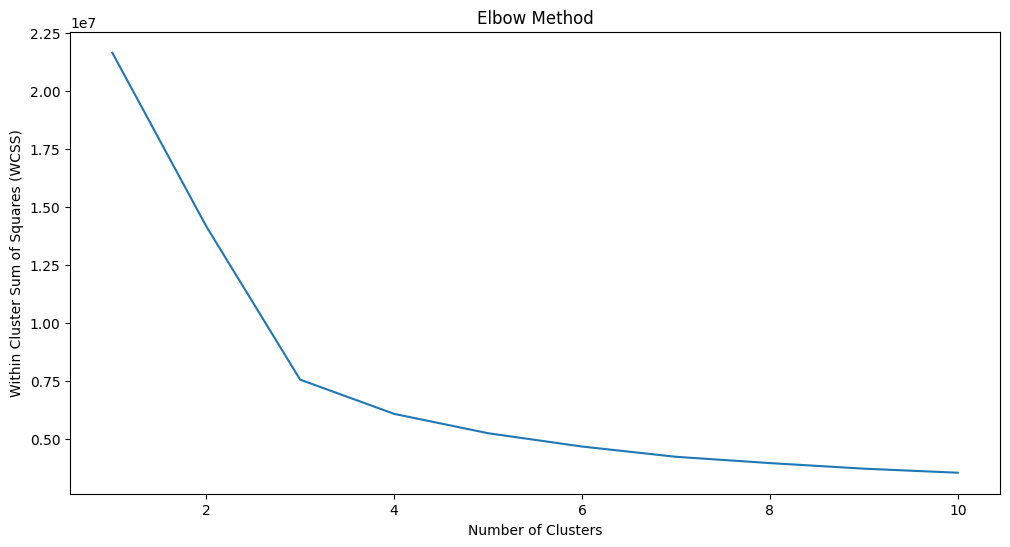

In [ ]:
# Plotting WCSS graph.
plt.figure(figsize=(12, 6), dpi=100)

plt.plot(range(1, 11), wcss)

plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')

plt.show()

In [ ]:
#Using StandardScaler to set all the columns in the dataframe to the same scale.
std_scaler = StandardScaler()
X = std_scaler.fit_transform(input_col_pandas_df)

X = pd.DataFrame(X, columns = input_col_pandas_df.columns)
X

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,year,month,quarter_of_year,hour,week_day_index
0,0.932568,-0.507801,-0.296287,0.606895,0.085683,0.396915,-0.481717,0.0,-0.315167,-1.014096,0.527390,1.562442
1,-1.072308,-0.507801,-0.258619,-0.347109,-0.723855,-0.546979,-0.446816,0.0,1.470067,0.986100,-2.057359,0.557654
2,0.932568,-0.507801,-0.228636,0.477076,-0.859745,-1.124049,-0.283183,0.0,-1.505323,-1.014096,-0.384874,1.060048
3,-1.072308,1.783904,-0.011937,0.278955,0.253514,0.404970,-0.615324,0.0,1.470067,0.986100,1.287611,-0.949529
4,0.932568,-0.507801,-0.017565,1.576164,1.065027,0.258777,0.179900,0.0,0.874989,0.986100,-0.993051,-1.451923
...,...,...,...,...,...,...,...,...,...,...,...,...
239694,-1.072308,-0.507801,-0.211534,-0.020663,-0.503177,-0.061881,-0.612374,0.0,-1.505323,-1.014096,-0.993051,1.060048
239695,0.932568,-0.507801,-0.905232,-1.229043,-0.273673,-0.438650,-0.195535,0.0,-1.505323,-1.014096,0.527390,1.562442
239696,-1.072308,-0.507801,-0.426718,0.014414,-0.127793,-0.200265,-0.553230,0.0,0.279911,0.986100,0.983523,1.060048
239697,0.932568,-0.507801,-0.177979,1.259494,0.429847,0.914889,-0.270414,0.0,0.874989,0.986100,0.375346,0.055259


In [ ]:
# We can see that the graph above levels off at around k=4. So we will use that as our number of clusters.
# Now we will create a k-means clustering model that uses 4 clusters (k=4)

kmeans_cluster = KMeans(n_clusters = 4, init = 'k-means++', random_state = 0)
clusters_prediction = kmeans_cluster.fit_predict(X)

kmeans_fit = kmeans_cluster.fit(X)

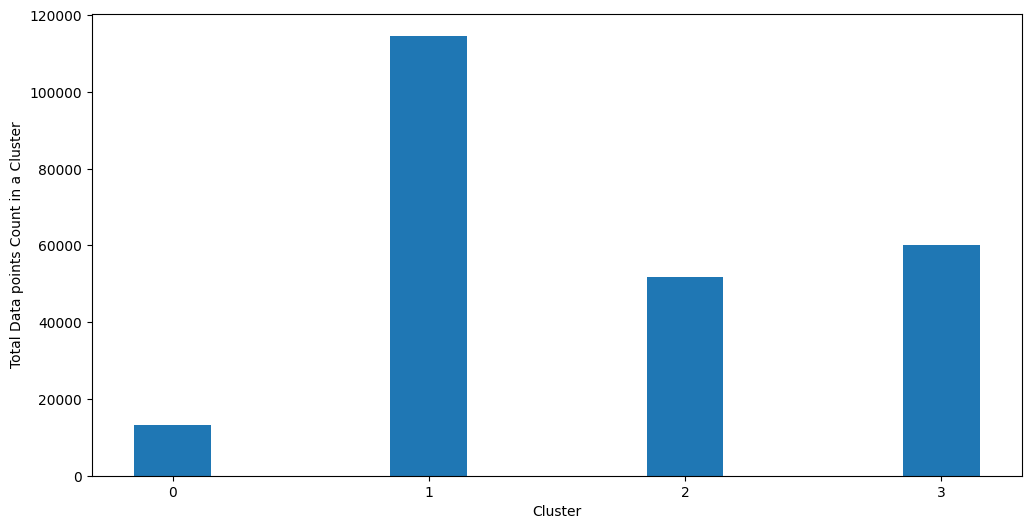

In [ ]:
# Graph out the size of each cluster.
input_col_pandas_df['cluster'] = clusters_prediction
cluster_counts = input_col_pandas_df.groupby(['cluster'])['cluster'].count()

plt.figure(figsize=(12, 6), dpi=100)

plt.bar(['0', '1', '2', '3'], cluster_counts.values, width = 0.3)

plt.xlabel('Cluster')
plt.ylabel('Total Data points Count in a Cluster')

plt.show()

In [ ]:
# Print total data points in each 4 clusters.
for i in range(len(cluster_counts.values)):
    print("Cluster: ", i, " Total Data Points: ", cluster_counts.values[i])

Cluster:  0  Total Data Points:  13224
Cluster:  1  Total Data Points:  114651
Cluster:  2  Total Data Points:  64249
Cluster:  3  Total Data Points:  47575


## Feature diagnose per cluster

In [ ]:
# Adding a cluster column in dataframes.
input_col_pandas_df['cluster'] = kmeans_cluster.labels_
X['cluster'] = kmeans_cluster.labels_

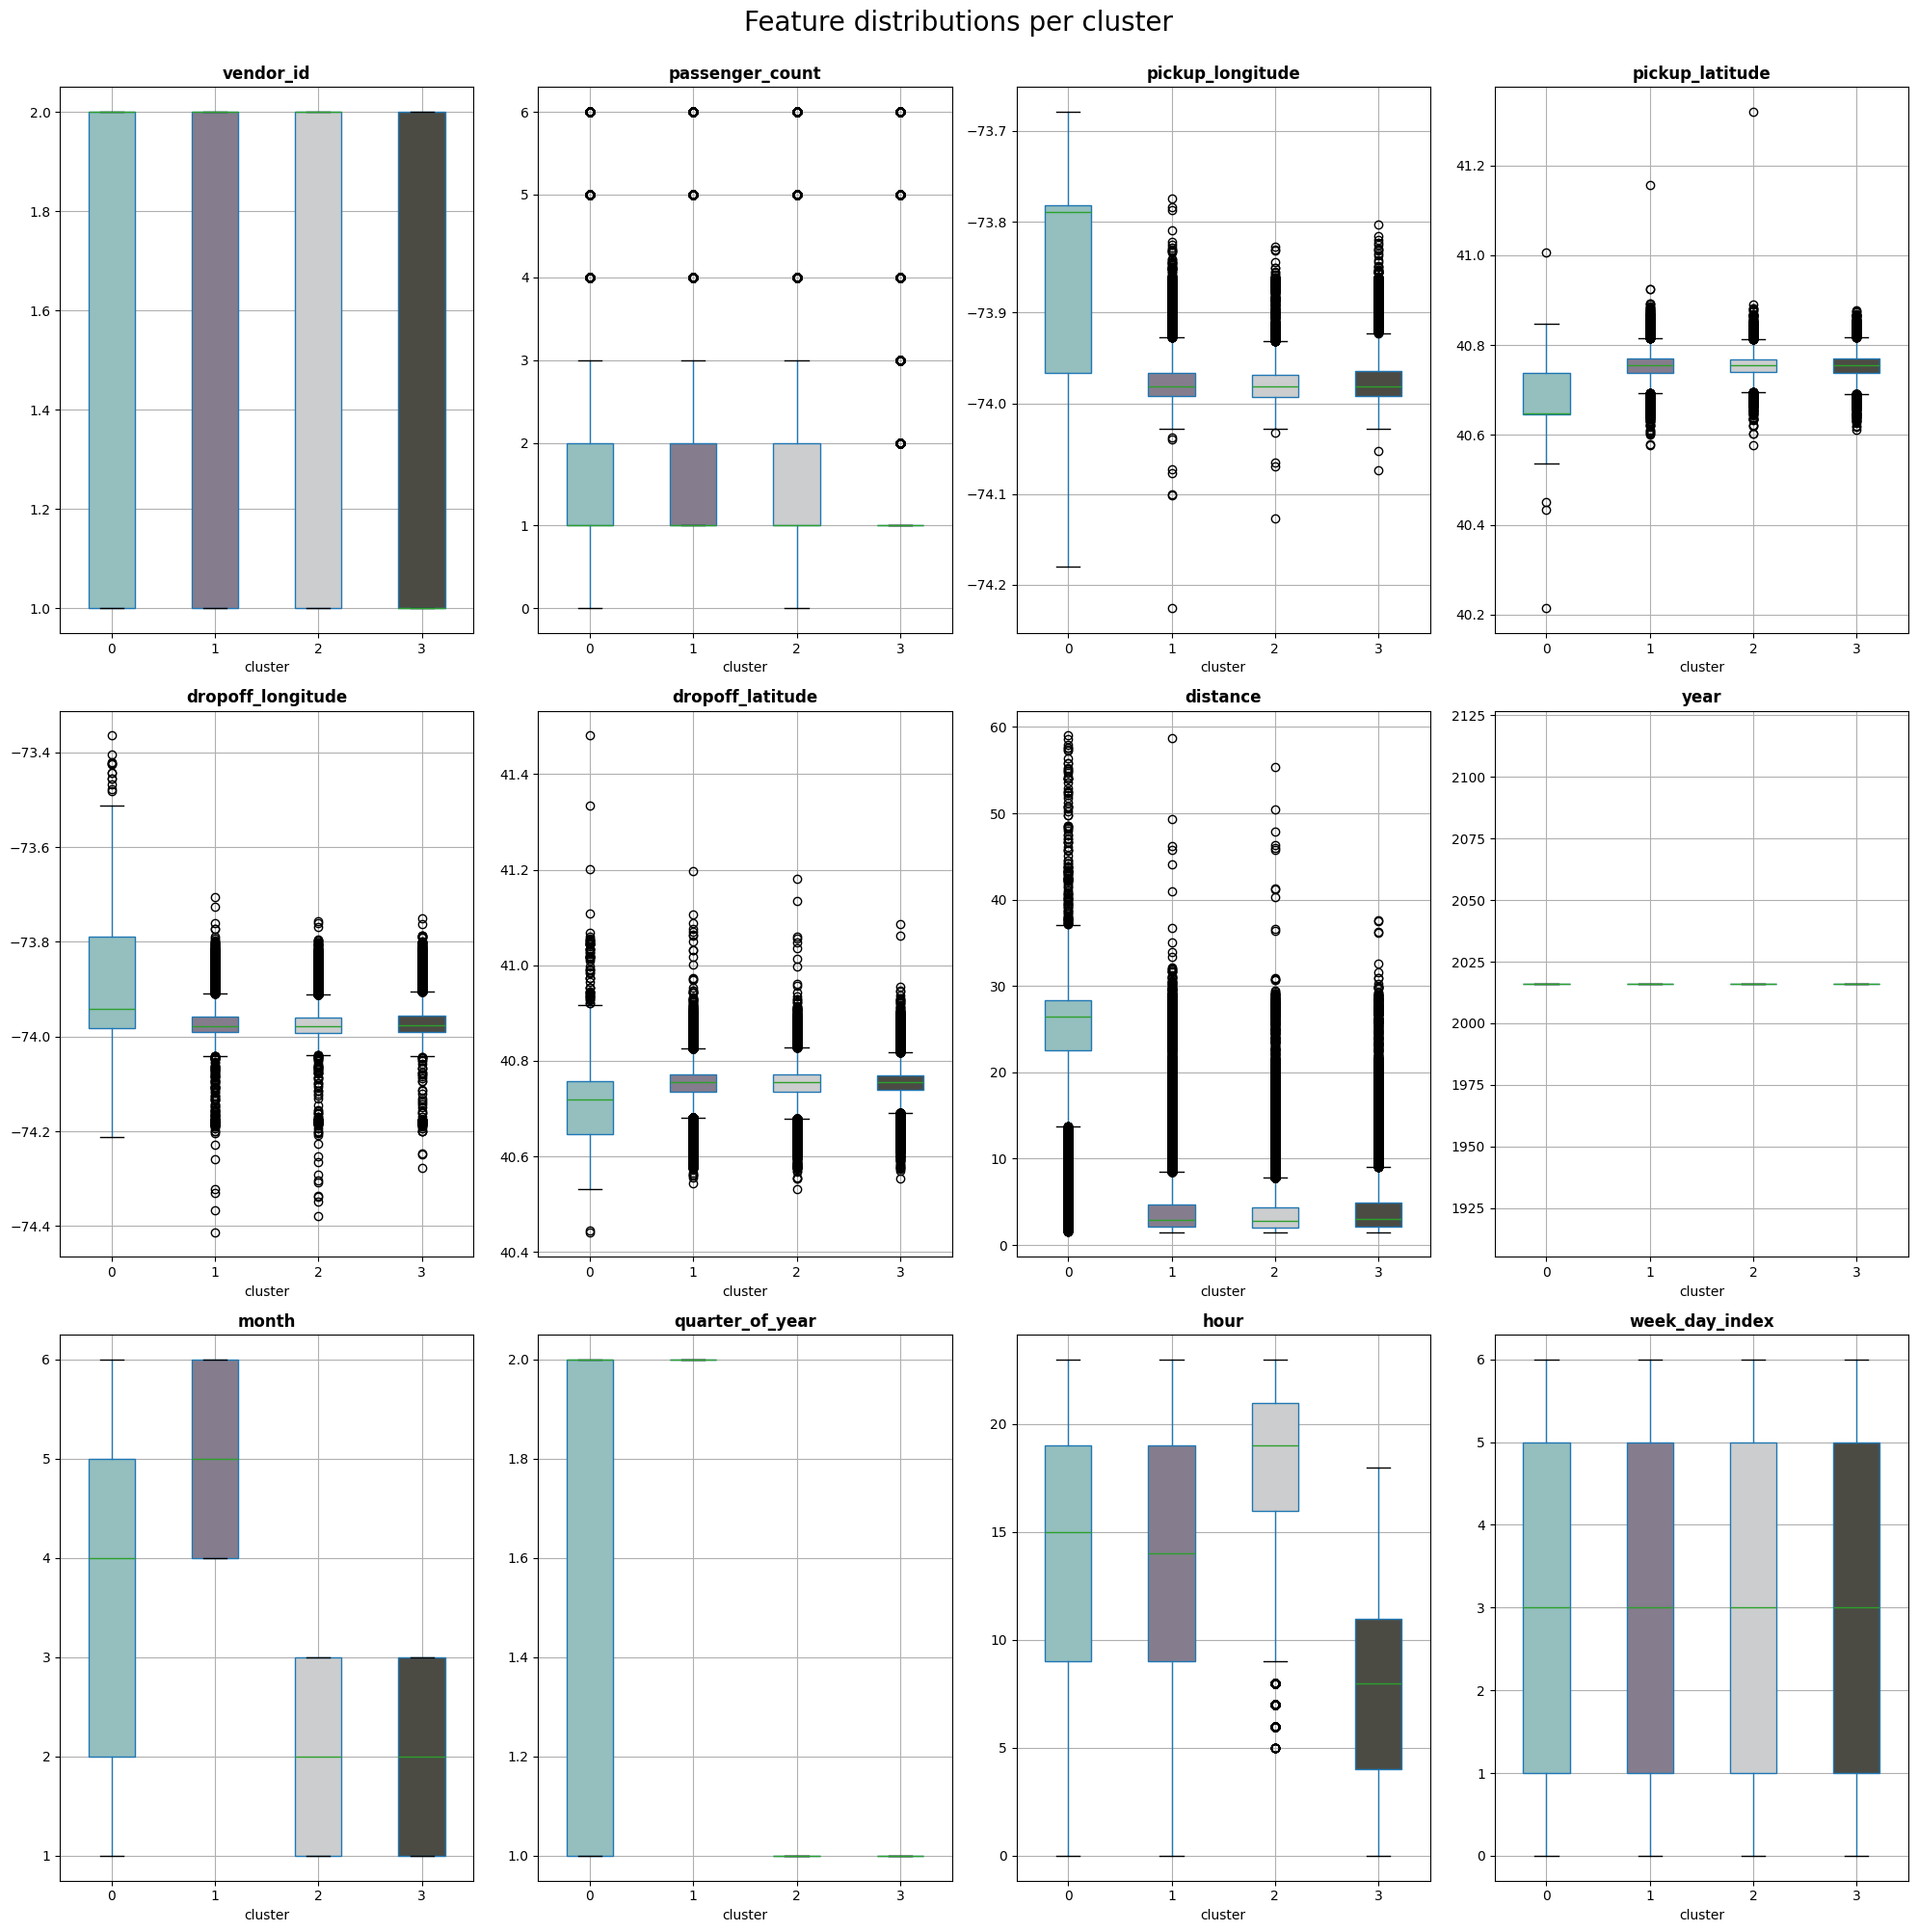

In [ ]:
# Getting features from kmeans model.
features = kmeans_cluster.feature_names_in_
n_cols = 4
n_rows = len(features) // n_cols + (len(features) % n_cols > 0)

fig = plt.figure(figsize = (20,20))

# Create a box for each feature in each cluster.
for n, feature in enumerate(features):
    ax = plt.subplot(n_rows, n_cols, n + 1)
    box = input_col_pandas_df[[feature, 'cluster']].boxplot(by = 'cluster', ax = ax, return_type = 'both', patch_artist = True)

    for row_key, (ax, row) in box.items():
        ax.set_xlabel('cluster')
        ax.set_title(feature, fontweight = "bold")
        for i, box in enumerate(row['boxes']):
            box.set_facecolor(cluster_colors[i])

fig.suptitle('Feature distributions per cluster', fontsize = 20, y = 1)
plt.tight_layout()
plt.show()

## Data Preparation for Radar

In [ ]:
# Calculate mean for each feature in each cluster.
X_mean = pd.concat([pd.DataFrame(X.mean().drop('cluster'), columns=['mean']), X.groupby('cluster').mean().T], axis = 1)
X_mean.drop(columns=['mean'], inplace=True)

X_mean

,0,1,2,3
vendor_id,0.059604,-0.010948,0.193171,-0.251057
passenger_count,0.033527,-0.002264,0.181743,-0.249303
pickup_longitude,2.639456,-0.151087,-0.163185,-0.149183
pickup_latitude,-2.206563,0.127759,0.129048,0.131175
dropoff_longitude,1.677560,-0.096481,-0.148192,-0.033657
dropoff_latitude,-1.060584,0.060874,0.056229,0.072166
distance,3.038353,-0.169072,-0.215574,-0.145969
year,0.000000,0.000000,0.000000,0.000000
month,0.026382,0.860949,-0.884691,-0.887380
quarter_of_year,0.025933,0.986100,-1.014096,-1.014096


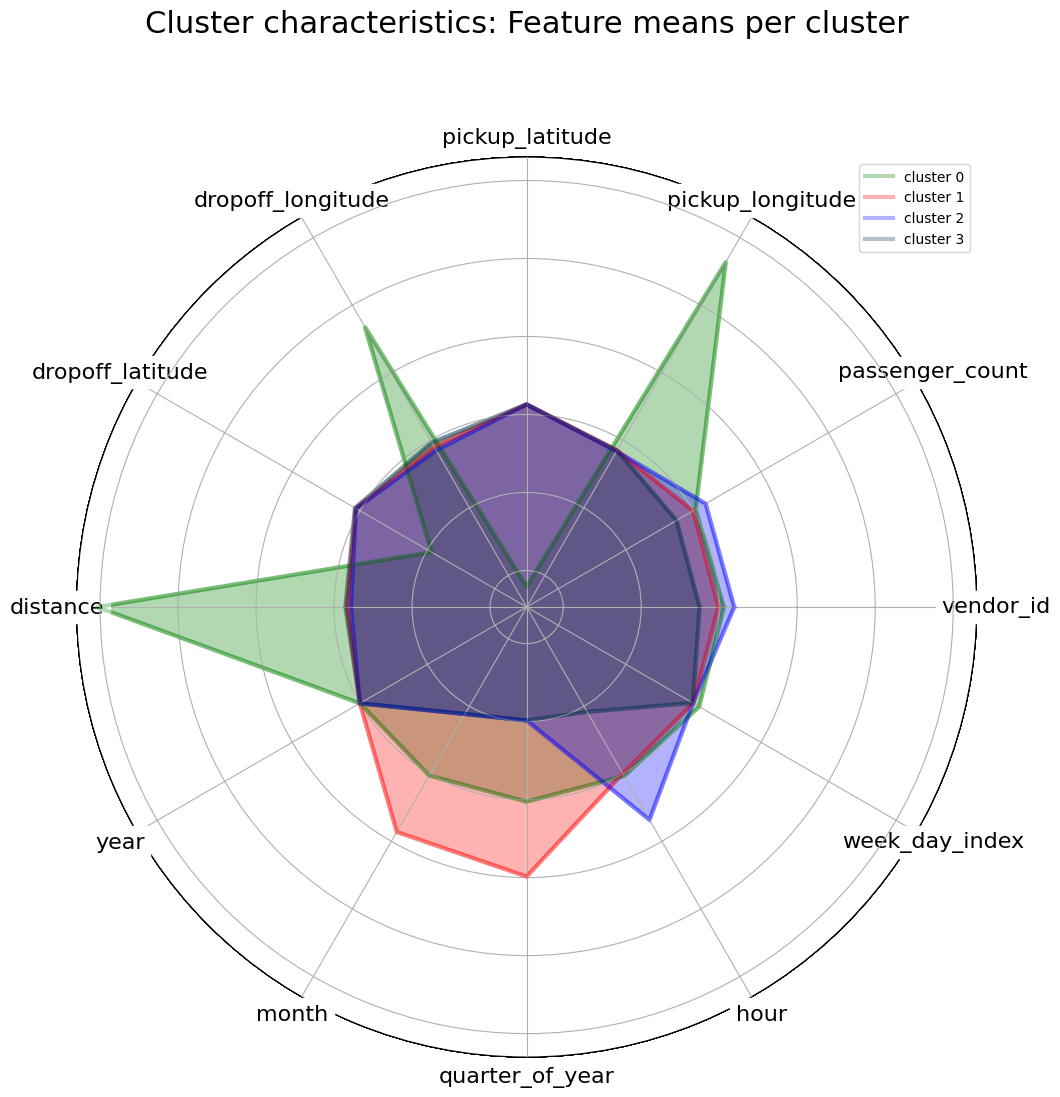

In [ ]:
class Radar(object):
    def __init__(self, figure, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)

        self.axes = [figure.add_axes(rect, projection = 'polar', label = 'axes%d' % i) for i in range(self.n)]
        self.ax = self.axes[0]

        # Feature names
        self.ax.set_thetagrids(self.angles, labels = title, fontsize = 16, backgroundcolor = "white",zorder = 999)
        self.ax.set_yticklabels([])

        for ax in self.axes[1:]:
            ax.xaxis.set_visible(False)
            ax.set_yticklabels([])
            ax.set_zorder(-99)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.spines['polar'].set_color('black')
            ax.spines['polar'].set_zorder(-99)

    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)
        kw['label'] = '_noLabel'
        self.ax.fill(angle, values,*args,**kw)

# Radar clusters.
radar_cluster_color = ["green", "red", "blue", "#003049"]
fig = plt.figure(figsize = (12, 10))
radar = Radar(fig, kmeans_cluster.feature_names_in_, np.unique(kmeans_cluster.labels_))

# Get data for each cluster and plot it in a radar.
for cluster in range(0, kmeans_cluster.n_clusters):
    cluster_data = X_mean[cluster].values.tolist()
    radar.plot(cluster_data,  '-', lw = 3, color = radar_cluster_color[cluster], alpha=0.3, label='cluster {}'.format(cluster))

radar.ax.legend()
radar.ax.set_title("Cluster characteristics: Feature means per cluster", size = 22, pad = 90)
plt.show()

#DL Models Implementation.................................................

#CNN..................................................................

Epoch 1/50, Loss: 0.6200
Epoch 2/50, Loss: 0.5510
Epoch 3/50, Loss: 0.4854
Epoch 4/50, Loss: 0.4245
Epoch 5/50, Loss: 0.3681
Epoch 6/50, Loss: 0.3159
Epoch 7/50, Loss: 0.2675
Epoch 8/50, Loss: 0.2220
Epoch 9/50, Loss: 0.1799
Epoch 10/50, Loss: 0.1421
Epoch 11/50, Loss: 0.1086
Epoch 12/50, Loss: 0.0799
Epoch 13/50, Loss: 0.0561
Epoch 14/50, Loss: 0.0375
Epoch 15/50, Loss: 0.0239
Epoch 16/50, Loss: 0.0153
Epoch 17/50, Loss: 0.0113
Epoch 18/50, Loss: 0.0112
Epoch 19/50, Loss: 0.0143
Epoch 20/50, Loss: 0.0194
Epoch 21/50, Loss: 0.0253
Epoch 22/50, Loss: 0.0308
Epoch 23/50, Loss: 0.0352
Epoch 24/50, Loss: 0.0377
Epoch 25/50, Loss: 0.0384
Epoch 26/50, Loss: 0.0372
Epoch 27/50, Loss: 0.0346
Epoch 28/50, Loss: 0.0311
Epoch 29/50, Loss: 0.0270
Epoch 30/50, Loss: 0.0229
Epoch 31/50, Loss: 0.0191
Epoch 32/50, Loss: 0.0159
Epoch 33/50, Loss: 0.0133
Epoch 34/50, Loss: 0.0115
Epoch 35/50, Loss: 0.0104
Epoch 36/50, Loss: 0.0099
Epoch 37/50, Loss: 0.0099
Epoch 38/50, Loss: 0.0103
Epoch 39/50, Loss: 0.

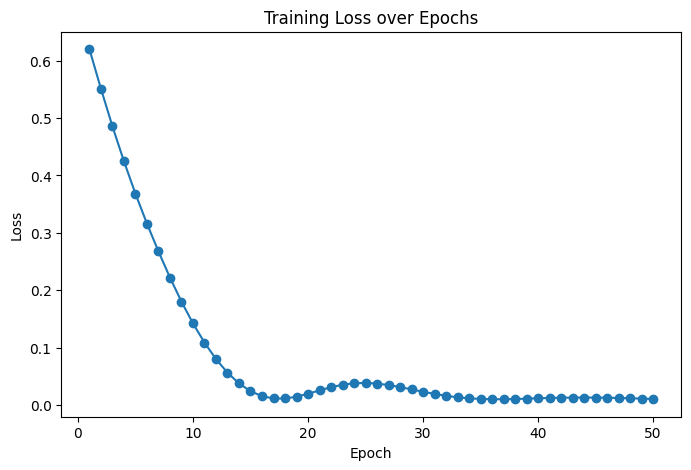

R² Score: -0.0445
Mean Absolute Error (MAE): 123.0689
Mean Absolute Percentage Error (MAPE): 7.17%
Accuracy (within 10% range): 64.29%


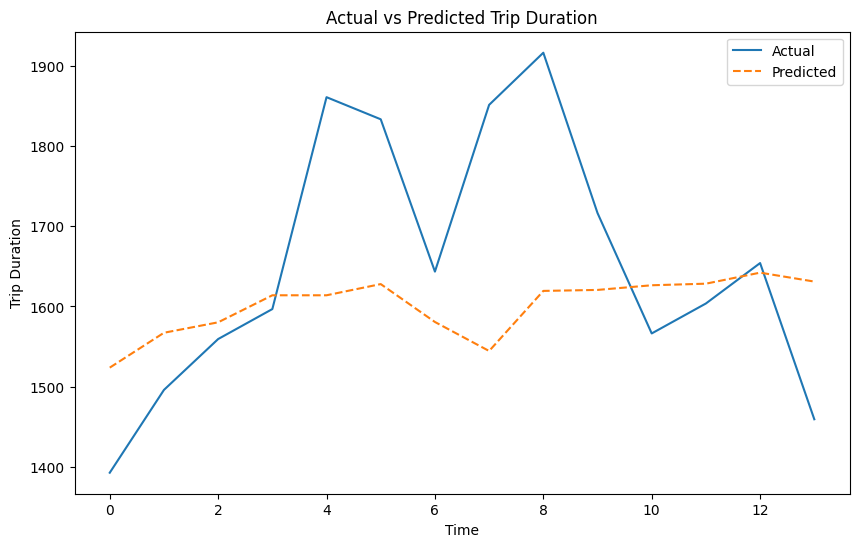

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error



# Data Preprocessing Function
def preprocess_data(df, time_column='hour', target_column='trip_duration', sequence_length=10):
    # Group by hour and aggregate trip duration
    df_grouped = df.groupby(time_column)[target_column].sum().reset_index()

    # Sorting to ensure time series order
    df_grouped = df_grouped.sort_values(by=time_column)

    # Normalizing the data
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(df_grouped[[target_column]])

    series = normalized_data.flatten()
    X, y = [], []
    for i in range(len(series) - sequence_length):
        X.append(series[i:i+sequence_length])
        y.append(series[i+sequence_length])

    return np.array(X), np.array(y), scaler, df_grouped


class CNNTimeSeries(nn.Module):
    def __init__(self):
        super(CNNTimeSeries, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(16 * 5, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Prepare data
X, y, scaler, df_grouped = preprocess_data(df)
X = X.reshape(X.shape[0], 1, X.shape[1])  # Reshape for CNN

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize and Train Model
model = CNNTimeSeries()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 50
losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(dataloader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

# Plot training loss
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

# Model Evaluation
model.eval()
predictions = model(X_train).detach().numpy()
actual_values = y_train.numpy()

# Reverse scaling
predictions = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(actual_values.reshape(-1, 1))

# Compute Evaluation Metrics
r2 = r2_score(actual_values, predictions)
mae = mean_absolute_error(actual_values, predictions)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100

# Compute Accuracy-like Metric
tolerance = 0.10  # 10% tolerance
correct_predictions = np.abs((actual_values - predictions) / actual_values) <= tolerance
accuracy = np.mean(correct_predictions) * 100

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy (within 10% range): {accuracy:.2f}%")

# Plot predictions vs actual values
plt.figure(figsize=(10,6))
plt.plot(actual_values, label='Actual')
plt.plot(predictions, label='Predicted', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Trip Duration')
plt.title('Actual vs Predicted Trip Duration')
plt.legend()
plt.show()

#LSTM................................................................

Epoch 1/50, Loss: 0.5784
Epoch 2/50, Loss: 0.5390
Epoch 3/50, Loss: 0.5008
Epoch 4/50, Loss: 0.4633
Epoch 5/50, Loss: 0.4260
Epoch 6/50, Loss: 0.3887
Epoch 7/50, Loss: 0.3508
Epoch 8/50, Loss: 0.3123
Epoch 9/50, Loss: 0.2728
Epoch 10/50, Loss: 0.2322
Epoch 11/50, Loss: 0.1906
Epoch 12/50, Loss: 0.1486
Epoch 13/50, Loss: 0.1069
Epoch 14/50, Loss: 0.0677
Epoch 15/50, Loss: 0.0342
Epoch 16/50, Loss: 0.0124
Epoch 17/50, Loss: 0.0100
Epoch 18/50, Loss: 0.0307
Epoch 19/50, Loss: 0.0566
Epoch 20/50, Loss: 0.0653
Epoch 21/50, Loss: 0.0563
Epoch 22/50, Loss: 0.0395
Epoch 23/50, Loss: 0.0235
Epoch 24/50, Loss: 0.0130
Epoch 25/50, Loss: 0.0086
Epoch 26/50, Loss: 0.0087
Epoch 27/50, Loss: 0.0116
Epoch 28/50, Loss: 0.0153
Epoch 29/50, Loss: 0.0189
Epoch 30/50, Loss: 0.0214
Epoch 31/50, Loss: 0.0228
Epoch 32/50, Loss: 0.0228
Epoch 33/50, Loss: 0.0217
Epoch 34/50, Loss: 0.0197
Epoch 35/50, Loss: 0.0171
Epoch 36/50, Loss: 0.0143
Epoch 37/50, Loss: 0.0118
Epoch 38/50, Loss: 0.0097
Epoch 39/50, Loss: 0.

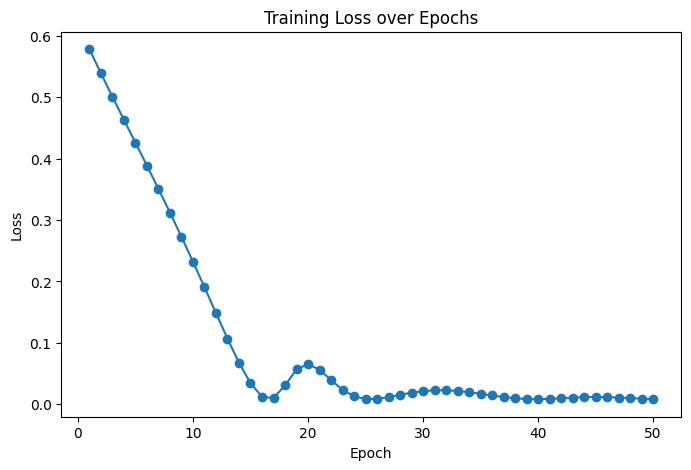

R² Score: 0.1338
Mean Absolute Error (MAE): 124.5137
Mean Absolute Percentage Error (MAPE): 7.55%
Accuracy (within 10% range): 71.43%


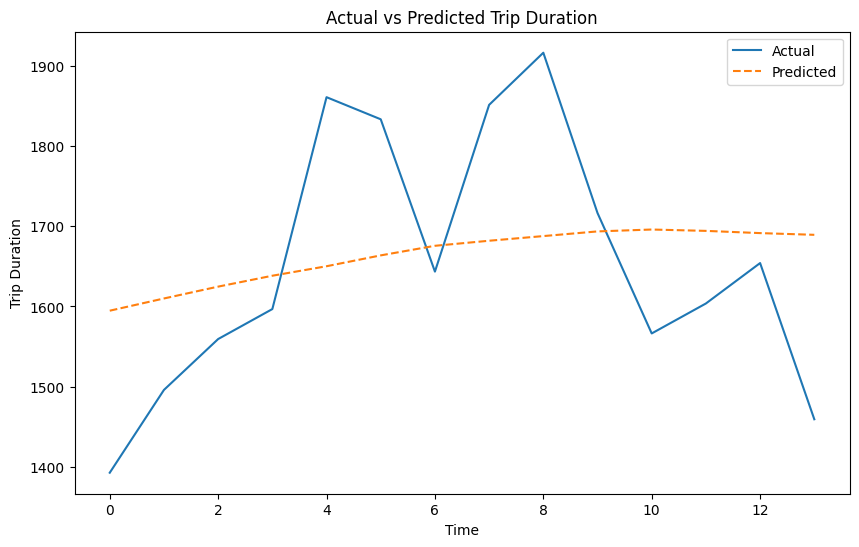

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Data Preprocessing Function
def preprocess_data(df, time_column='hour', target_column='trip_duration', sequence_length=10):
    # Group by hour and aggregate trip duration
    df_grouped = df.groupby(time_column)[target_column].sum().reset_index()

    # Sorting to ensure time series order
    df_grouped = df_grouped.sort_values(by=time_column)

    # Normalizing the data
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(df_grouped[[target_column]])

    series = normalized_data.flatten()
    X, y = [], []
    for i in range(len(series) - sequence_length):
        X.append(series[i:i+sequence_length])
        y.append(series[i+sequence_length])

    return np.array(X), np.array(y), scaler, df_grouped

# Define LSTM Model
class LSTMTimeSeries(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMTimeSeries, self).__init__()

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM forward pass
        out, (hn, cn) = self.lstm(x)

        # Use the output of the last time step for prediction
        out = self.fc(out[:, -1, :])

        return out


# Prepare data
X, y, scaler, df_grouped = preprocess_data(df)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM input (samples, timesteps, features)

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize Model
model = LSTMTimeSeries(input_size=1, hidden_size=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 50
losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    losses.append(epoch_loss / len(dataloader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

# Plot training loss
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

# Model Evaluation
model.eval()
predictions = model(X_train).detach().numpy()
actual_values = y_train.numpy()

# Reverse scaling
predictions = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(actual_values.reshape(-1, 1))

# Compute Evaluation Metrics
from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(actual_values, predictions)
mae = mean_absolute_error(actual_values, predictions)
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100

# Compute Accuracy-like Metric
tolerance = 0.10  # 10% tolerance
correct_predictions = np.abs((actual_values - predictions) / actual_values) <= tolerance
accuracy = np.mean(correct_predictions) * 100

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy (within 10% range): {accuracy:.2f}%")

# Plot predictions vs actual values
plt.figure(figsize=(10,6))
plt.plot(actual_values, label='Actual')
plt.plot(predictions, label='Predicted', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Trip Duration')
plt.title('Actual vs Predicted Trip Duration')
plt.legend()
plt.show()

#Comparison Between DL Models.................

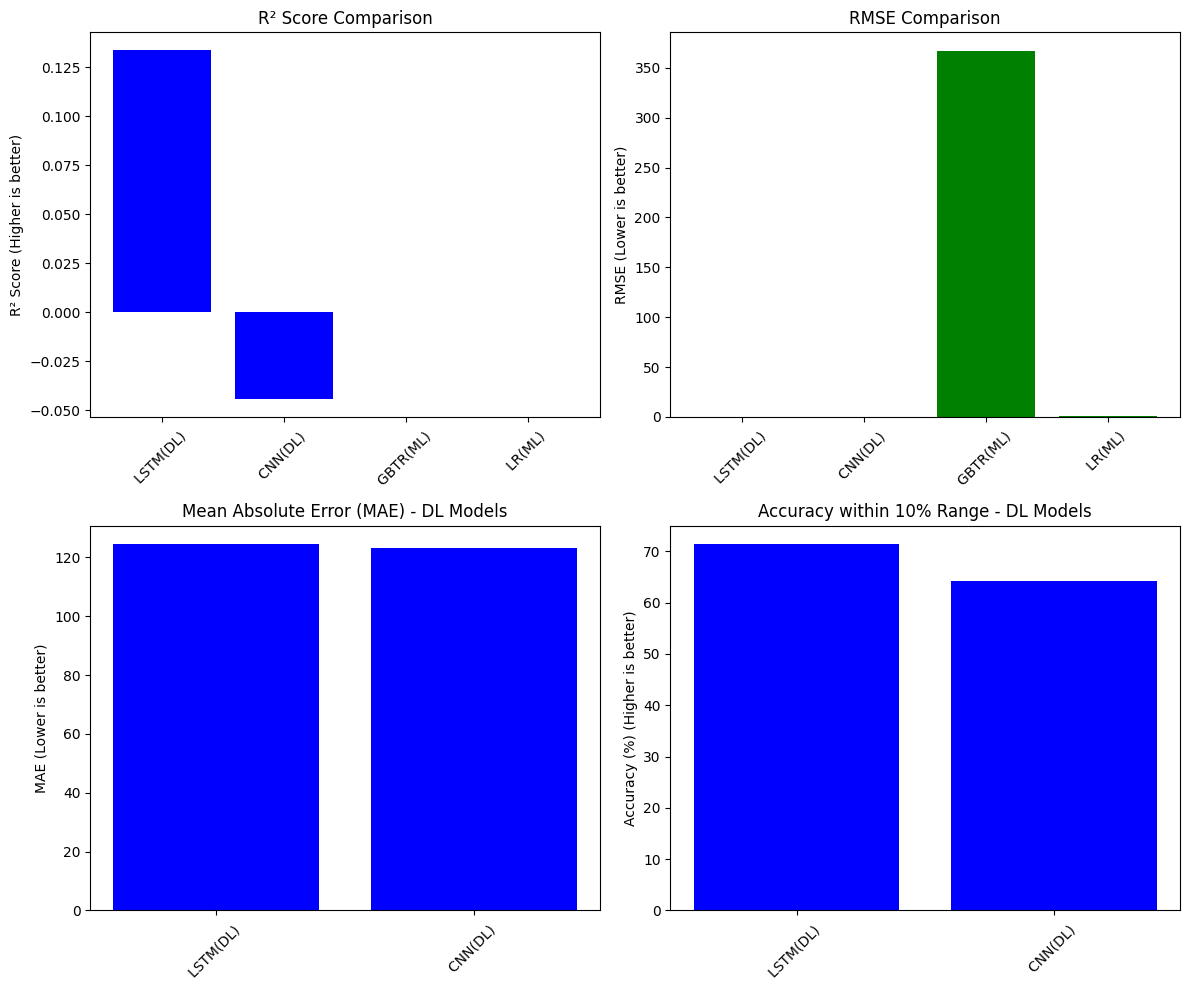

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(models, r2_scores, rmse_values, mae_values, accuracy_values):
    # Filter out None values and corresponding models
    valid_indices = [
        i for i in range(len(models))
        if (r2_scores[i] is not None or
            rmse_values[i] is not None or
            mae_values[i] is not None or
            accuracy_values[i] is not None)
    ]

    # Create filtered lists
    filtered_models = [models[i] for i in valid_indices]
    filtered_r2_scores = [r2_scores[i] if r2_scores[i] is not None else 0 for i in valid_indices]
    filtered_rmse_values = [rmse_values[i] if rmse_values[i] is not None else 0 for i in valid_indices]
    filtered_mae_values = [mae_values[i] for i in valid_indices if mae_values[i] is not None]
    filtered_accuracy_values = [accuracy_values[i] for i in valid_indices if accuracy_values[i] is not None]

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    # R² Score Comparison
    ax[0, 0].bar(filtered_models, filtered_r2_scores,
                 color=["blue" if "DL" in model else "green" for model in filtered_models])
    ax[0, 0].set_title("R² Score Comparison")
    ax[0, 0].set_ylabel("R² Score (Higher is better)")
    ax[0, 0].tick_params(axis='x', rotation=45)

    # RMSE Comparison
    ax[0, 1].bar(filtered_models, filtered_rmse_values,
                 color=["gray" if val == 0 else "green" for val in filtered_rmse_values])
    ax[0, 1].set_title("RMSE Comparison")
    ax[0, 1].set_ylabel("RMSE (Lower is better)")
    ax[0, 1].tick_params(axis='x', rotation=45)

    # MAE Comparison (for DL models only)
    if filtered_mae_values:
        ax[1, 0].bar(
            [model for model in filtered_models if any(dl in model for dl in ["LSTM", "CNN", "DL"])],
            filtered_mae_values,
            color="blue"
        )
        ax[1, 0].set_title("Mean Absolute Error (MAE) - DL Models")
        ax[1, 0].set_ylabel("MAE (Lower is better)")
        ax[1, 0].tick_params(axis='x', rotation=45)
    else:
        ax[1, 0].text(0.5, 0.5, "No MAE Data Available",
                      horizontalalignment='center',
                      verticalalignment='center')
        ax[1, 0].set_title("Mean Absolute Error (MAE) - DL Models")

    # Accuracy within 10% range (for DL models only)
    if filtered_accuracy_values:
        ax[1, 1].bar(
            [model for model in filtered_models if any(dl in model for dl in ["LSTM", "CNN", "DL"])],
            filtered_accuracy_values,
            color="blue"
        )
        ax[1, 1].set_title("Accuracy within 10% Range - DL Models")
        ax[1, 1].set_ylabel("Accuracy (%) (Higher is better)")
        ax[1, 1].tick_params(axis='x', rotation=45)
    else:
        ax[1, 1].text(0.5, 0.5, "No Accuracy Data Available",
                      horizontalalignment='center',
                      verticalalignment='center')
        ax[1, 1].set_title("Accuracy within 10% Range - DL Models")

    plt.tight_layout()
    plt.show()

# Example usage with dynamic data
models = ["LSTM(DL) ", "CNN(DL) ", "GBTR(ML) ", "LR(ML) "]
r2_scores = [0.1338, -0.0445, None, None]
rmse_values = [None, None, 367.352, 0.504]
mae_values = [124.5137, 123.0689, None, None]
accuracy_values = [71.43, 64.29, None, None]

plot_model_comparison(models, r2_scores, rmse_values, mae_values, accuracy_values)